# parm@frosst-y to SMIRFF

This notebook provides examples/utility functionality to assist with conversion of parm@frosst or relatives to SMIRFF format. Particularly, Christopher Bayly is generating modified AMBER `frcmod` files where the first entry for each parameter (i.e. `CT-CT-CT`) is replaced by the relevant SMIRKS pattern, for conversion into SMIRFF FFXML format. 

This notebook will:
1. Convert a specified smirks-frcmod file to SMIRFF FFXML
2. Generate (or take in) a set of molecules in OpenEye oemol format
3. Use the SMIRFF `ForceField` class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter.

Bayly will potentially also update the notebook with visualization for 3(b) and 3(c).


**Authors**:
* David L. Mobley (UCI)


## 1. Convert specified SMIRKS `frcmod` file to SMIRFF FFXML

In [15]:
# Input and output info
infile = 'example.frcmod' # frcmod file to convert
outfile = 'example.ffxml' # Output SMIRFF FFXML
template = 'template.ffxml' # Template FFXML file without parameters (but with remainder of contents)
testfile = 'example_plusgeneric.ffxml' # Test FFXML file which also provides a generic for every force type

# Imports
from convert_frcmod import *
import openeye.oechem as oechem
import openeye.oeiupac as oeiupac
import openeye.oeomega as oeomega
from smarty.forcefield import *
from smarty.forcefield_utils import get_molecule_parameterIDs
from smarty.utils import *
% matplotlib inline
import matplotlib
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

# Convert
convert_frcmod_to_ffxml( infile, template, outfile)

## 2. Generate or take in a set of molecules in OpenEye OEMol format

Here we will take in the ZINC parm@frosst subset from CCL (which is also packaged with SMARTY) and read all the molecules from it.

In [35]:
# Use utils wrapper functions to find the file and read all of the molecules
oemols = read_molecules( get_data_filename('molecules/zinc-subset-tripos.mol2.gz'))

# For use later, generate isomeric SMILES for these so we can easily look up molecules by smiles
isosmiles_to_mol = {}
for mol in oemols:
    smi = oechem.OECreateIsoSmiString(mol)
    isosmiles_to_mol[smi] = OEMol(mol)

Loading molecules from '/Users/dmobley/anaconda/lib/python2.7/site-packages/smarty-0.1.2-py2.7.egg/smarty/data/molecules/zinc-subset-tripos.mol2.gz'...
7505 molecules read
1.562 s elapsed


## 3. Determine parameter usage in molecules

Here we will use the SMIRFF ForceField class to determine (a) which parameters are used in which molecules; (b) which molecules contain a specified parameter; and (c) which molecules do NOT contain a specified parameter. We begin by just loading the SMIRFF forcefield we generated in section 1.

In [51]:
# Load SMIRFF FFXML
#ff = ForceField(outfile) # We will use this below to access details of parameters
ff = ForceField(testfile)

### 3(a). Determine which parameters are used in which molecules

Here we determine which parameters are actually used in which molecules, and make a couple example plots of the frequency of parameter occurrences for some of our example parameters.

In [64]:
# Use utility function from forcefield_utils to get which parameters are in which molecules
# and which molecules each parameter occurs in. 
# The returns are dictionaries, and molecule identifiers are isomeric smiles generated from the OEMols
# USE TEST FILE CONTAINING GENERICS RATHER THAN OUTPUT FILE FOR NOW
#parameters_by_molecule, parameters_by_ID = get_molecule_parameterIDs( oemols, outfile) #Slow
parameters_by_molecule, parameters_by_ID = get_molecule_parameterIDs( oemols, testfile) #Slow 

# Prep for making graphs - determine all parameters used at all
# (TO DO - probably would be useful to determine if any parameters aren't used at all)
param_ids = set()
for key in parameters_by_molecule:
    param_ids = param_ids.union(set(parameters_by_molecule[key]))

# Count occurrences of each parameter
param_id_counts = {}
for param_id in param_ids:
    param_id_counts[param_id] = 0
    for key in parameters_by_molecule:
        param_id_counts[param_id] += parameters_by_molecule[key].count(param_id)

For fun/info, do a quick graph of frequency of occurrence of particular parameters. Here, let's just do bond parameters

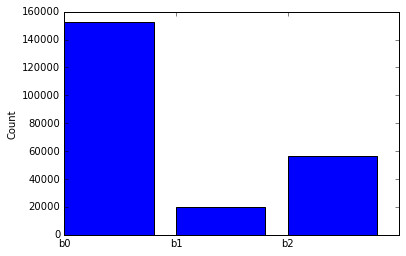

{'i1': 53130, 'i0': 490027, 'a1': 16128, 'a0': 368935, 'a2': 1621, 'b0': 152758, 'b1': 19634, 'b2': 56754, 'n0': 128656, 'n1': 87152, 'n2': 996}


In [53]:
# Graph occurrences of bond parameters
bond_ids = [ pid for pid in param_ids if pid[0]=='b']
bond_ids.sort()
counts_bonds = [param_id_counts[bond_id] for bond_id in bond_ids]
indices = np.arange(len(bond_ids))
fix, ax = plt.subplots()
rects2 = ax.bar(indices, counts_bonds )
ax.set_ylabel('Count')
ax.set_xticks( indices)
ax.set_xticklabels( bond_ids)
plt.show()

### 3(b)-3(c). Determine which molecules do/do not contain selected parameter

Determine which molecules do and do not contain a specified parameter; give access to isomeric smiles and OEMol for each molecule in each case.

In [60]:
# INPUT: Pick what parameter to look at
parameter_id = 't3' 

# For info, get details of that parameter
params = ff.getParameter(paramID=parameter_id)
print("For parameter %s, the relevant parameters are:" % parameter_id)
print(params)

# Find molecules which do/do not use that parameter
mols_with_param = []
mols_wo_param = []
for isosmi in parameters_by_molecule:
    # Store a tuple of (isomeric smiles, oemol) for each
    if parameter_id in parameters_by_molecule[isosmi]:
        mols_with_param.append( (isosmi, isosmiles_to_mol[isosmi] ))
    else:
        mols_wo_param.append( (isosmi, isosmiles_to_mol[isosmi] ))

print("\nThere are %s molecules containing that parameter and %s which do not, out of %s.\n" % (len(mols_with_param), len(mols_wo_param), len(isosmiles_to_mol)))

# Print first 10 molecules not containing parameter
print("First 10 molecules not containing that parameter:")
for i in range(10):
    print("   %s" % mols_wo_param[i][0])
# Print first 10 molecules containing parameter
print("\nFirst 10 molecules containing that parameter:")
for i in range(10):
    print("   %s" % mols_with_param[i][0])


For parameter a2, the relevant parameters are:
{'smirks': '[#6:1]~[#6:2]~[#8H1:3]', 'k': '160.0', 'angle': '120.00', 'id': 'a2'}

There are 731 molecules containing that parameter and 6774 which do not, out of 7505.

First 10 molecules not containing that parameter:
   CS(=O)(=O)N1CCC(CC1)n2cc(nn2)c3ccsc3
   c1cc2cccc3c2c(c1)c(=C(C#N)C#N)[nH]3
   CCSc1nnc(n1C)CSc2c([nH]c3c2cccc3)C
   c1ccc(cc1)c2cc(=O)[nH]c(=O)s2
   Cc1ccc(cc1)C2=CSNC(=N2)c3ccccc3OC
   c1nc2c(c(n1)N)NC(=O)C2
   c1nc2n(n1)C(C(=O)N2)CC(=O)[O-]
   CN1C(=O)c2ccccc2C(=C3C=CC(=O)C=C3)N1
   CC(=O)C1=C(c2ccccc2S(=O)(=O)N1)[O-]
   Cc1cc(=O)n2c(n1)sc(n2)n3cnc(n3)C#N

First 10 molecules containing that parameter:
   Cc1cc(on1)c2c(n(c(=O)n(c2=O)C)C)O
   c1cn2c(nc1=[NH2+])SC3C2OC(C3O)CO
   c1ccc(c(c1)C2=NC(=Cc3ccco3)C(=N2)O)Br
   c1ccc(cc1)C#CC2(c3ccccc3C(=O)c4c2cncc4)O
   CC(C)(C)OC(=O)NC1CC(C=C1)O
   CCOC(=O)[NH+]=c1cc(cc(o1)O)O
   c1ccc2cc3c(cc2c1)C4(c5ccccc5C(=O)C4(O3)O)O
   C1C(=CC(=O)[O-])C(OC1=O)(CCC(=O)[O-])O
   c1ccc(cc1)C